### Библиотеки

In [9]:
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F

from warnings import filterwarnings
filterwarnings('ignore')

### Загрузка кадров

In [10]:
VIDEO_PATH = "crowd.mp4"

cap = cv2.VideoCapture(VIDEO_PATH)
fps_video = int(cap.get(cv2.CAP_PROP_FPS))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")

out_yolo = cv2.VideoWriter("yolo_output.mp4", fourcc, fps_video, (w, h))
out_frcnn = cv2.VideoWriter("frcnn_output.mp4", fourcc, fps_video, (w, h))

frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()

print(f"Загружено кадров: {len(frames)}")

Загружено кадров: 705


### Порог для детекции

In [11]:
CONF_THRESHOLD = 0.5

### YOLOv8

In [12]:
yolo = YOLO("yolov8n.pt")

start = time.time()
yolo_detections = 0
yolo_confidences = []

for frame in frames:
    results = yolo.predict(frame, conf=CONF_THRESHOLD, classes=[0], verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    yolo_confidences.extend(scores)
    yolo_detections += len(boxes)

    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = map(int, box)
        label = f'Person: {score:.2f}'
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    out_yolo.write(frame)

yolo_time = time.time() - start
yolo_fps = len(frames) / yolo_time


print(f"YOLOv8:")
print(f"  FPS: {yolo_fps:.2f}")
print(f"  Среднее число детекций: {yolo_detections / len(frames):.2f}")

YOLOv8:
  FPS: 32.51
  Среднее число детекций: 7.50


### Faster R-CNN

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

frcnn = fasterrcnn_resnet50_fpn(pretrained=True)
frcnn.to(device)
frcnn.eval()

start = time.time()
frcnn_detections = 0
frcnn_confidences = []
for frame in frames:
    img_tensor = F.to_tensor(frame).to(device)

    with torch.no_grad():
        preds = frcnn([img_tensor])[0]

    boxes = preds["boxes"].cpu().numpy()
    labels = preds["labels"].cpu().numpy()
    scores = preds["scores"].cpu().numpy()

    mask = (labels == 1) & (scores > CONF_THRESHOLD)
    boxes = boxes[mask]
    scores = scores[mask]
    frcnn_confidences.extend(scores)

    frcnn_detections += len(boxes)

    for box, score in zip(boxes, scores):
        x1, y1, x2, y2 = map(int, box)
        label = f"Person: {score:.2f}"
        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    out_frcnn.write(frame)

frcnn_time = time.time() - start
frcnn_fps = len(frames) / frcnn_time

out_yolo.release()
out_frcnn.release()

print(f"Faster R-CNN:")
print(f"  FPS: {frcnn_fps:.2f}")
print(f"  Среднее число детекций: {frcnn_detections / len(frames):.2f}")

Faster R-CNN:
  FPS: 7.72
  Среднее число детекций: 26.33


### Статистика и результаты

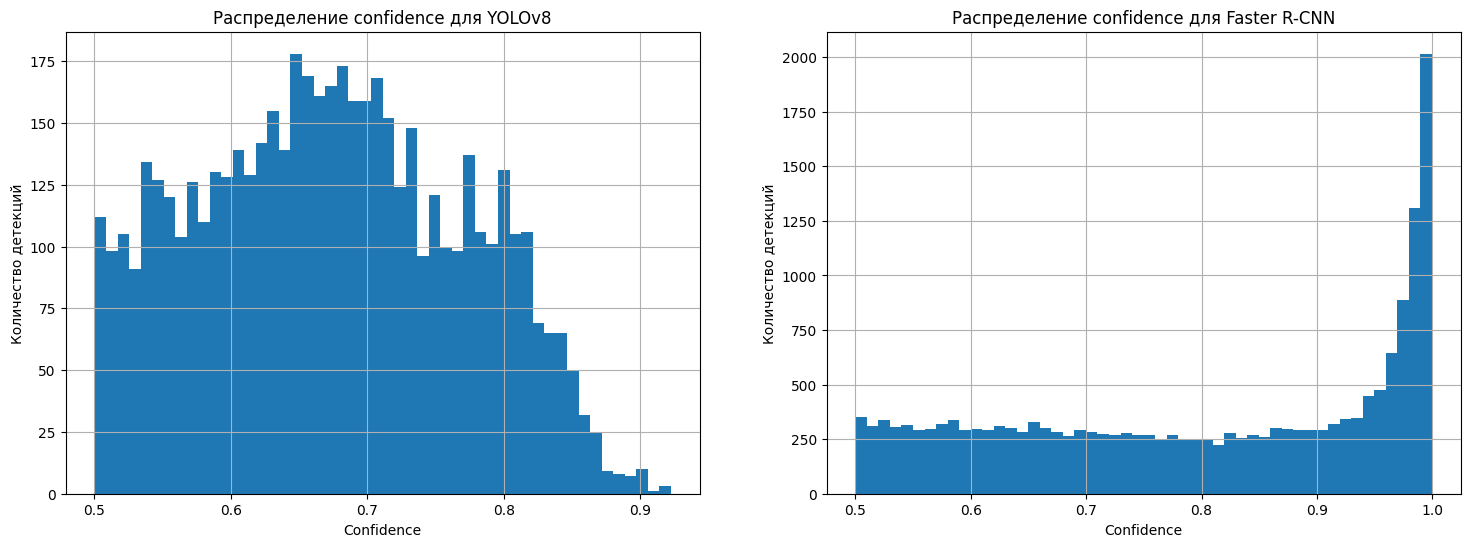

In [14]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.hist(yolo_confidences, bins=50)
plt.xlabel("Confidence")
plt.ylabel("Количество детекций")
plt.title("Распределение confidence для YOLOv8")
plt.grid(True)
plt.subplot(122)
plt.hist(frcnn_confidences, bins=50)
plt.xlabel("Confidence")
plt.ylabel("Количество детекций")
plt.title("Распределение confidence для Faster R-CNN")
plt.grid(True)
plt.show()

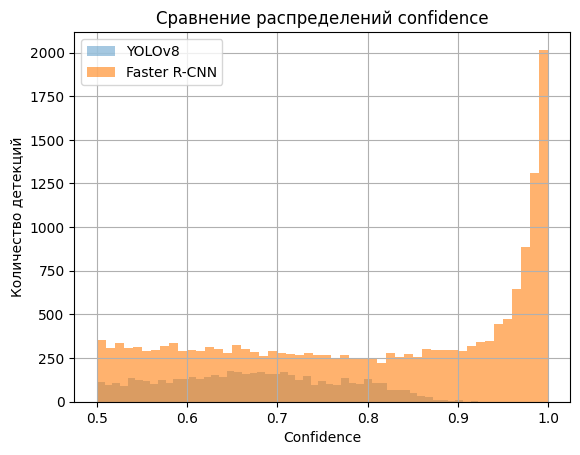

In [15]:
plt.figure()
plt.hist(yolo_confidences, bins=50, alpha=0.4, label="YOLOv8")
plt.hist(frcnn_confidences, bins=50, alpha=0.6, label="Faster R-CNN")
plt.xlabel("Confidence")
plt.ylabel("Количество детекций")
plt.title("Сравнение распределений confidence")
plt.legend()
plt.grid(True)
plt.show()

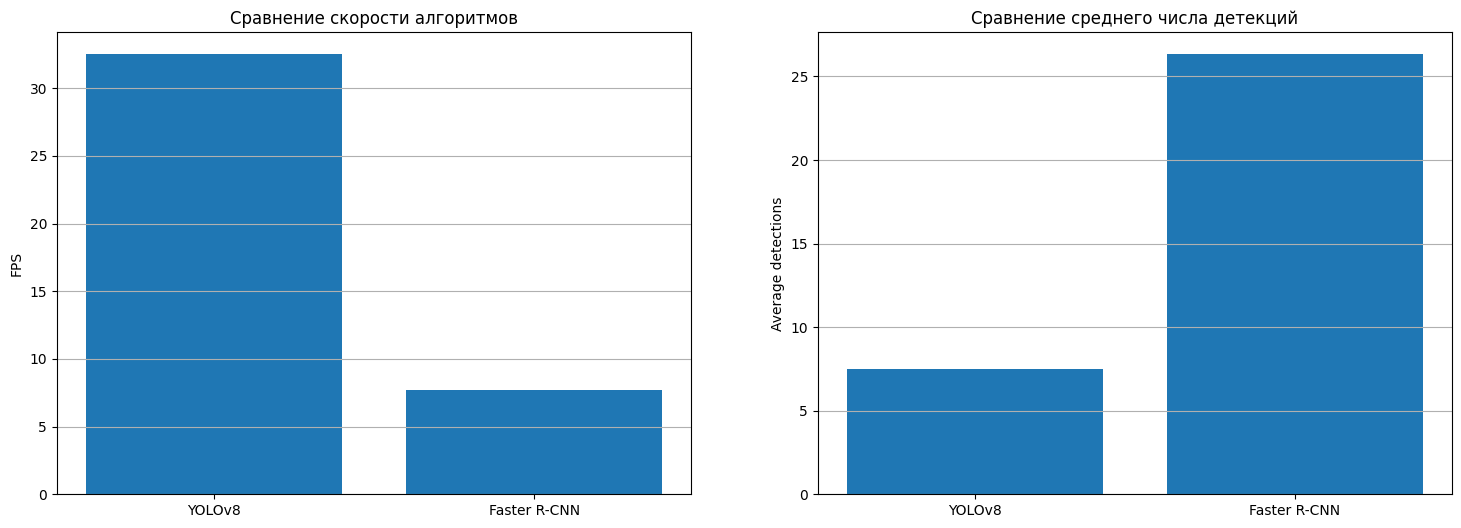

In [16]:
models = ["YOLOv8", "Faster R-CNN"]
fps = [yolo_fps, frcnn_fps]
detections = [yolo_detections / len(frames), frcnn_detections / len(frames)]

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(models, fps)
plt.ylabel("FPS")
plt.title("Сравнение скорости алгоритмов")
plt.grid(axis="y")
plt.subplot(122)
plt.bar(models, detections)
plt.ylabel("Average detections")
plt.title("Сравнение среднего числа детекций")
plt.grid(axis="y")
plt.show()


### Выводы:

#### Как видно из распределения confidence, модель Faster R-CNN выигрывает в точности по сравнению с YOLOv8. Но высокое значение точности усугубляются медленной скоростью инференса (fps низкое ~8-12 Гц), что непригодно для работы в реальном времени. У YOLOv8 же наоборот скорость realtime (~30 Гц), с которой работают в основном все камеры видеонаблюдения.

### Обоснование выбора наиболее предпочтительного алгоритма.

####  Для плотной толпы или офлайн анализа можно использовать Faster R-CNN, но в большинстве практических сценариев скорость важнее максимальной точности. Наиболее предпочтительным алгоритмом для распознавания людей на видео является YOLOv8. Он обеспечивает оптимальный баланс между скоростью, точностью и вычислительными ресурсами, что делает его применимым для задач реального времени.

### Шаги по дальнейшему улучшению качества распознавания и производительности.

#### 1) Подбор и калибровка порога confidence (анализ распределения confidence)
#### 2) Дообучение данных (повороты, масштаб, яркость, шумы)
#### 3) Постобработка и фильтрация детекций (Non-Maximum Suppression)
#### 4) Оптимизация производительности (Снижение разрешения кадра)